In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import warnings
warnings.filterwarnings('ignore') 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import random
import os
import glob

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report, confusion_matrix
)

import tensorflow as tf
from tensorflow.random import set_seed

from tensorflow.keras.layers import (
    Conv2D, Flatten, MaxPooling2D, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
)
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC, F1Score
from tensorflow.keras.applications import VGG16, ResNet50V2, DenseNet121, EfficientNetB5
from tensorflow.keras.optimizers import Adam, Adamax, SGD

from keras.callbacks import ReduceLROnPlateau

2024-06-19 23:10:25.450138: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-19 23:10:25.450242: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-19 23:10:25.573495: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
SEED = 24756
random.seed(SEED)
np.random.seed(SEED)
set_seed(SEED)

In [6]:
print(tf.__version__)

2.15.0


In [7]:
train_dir = '../input/chest-xray-pneumonia/chest_xray/train'
val_dir = '../input/chest-xray-pneumonia/chest_xray/val'
test_dir = '../input/chest-xray-pneumonia/chest_xray/test'
# Get number of images
num_pneumonia = len(os.listdir(os.path.join(train_dir, "PNEUMONIA")))
num_normal = len(os.listdir(os.path.join(train_dir, "NORMAL")))
# Calculate weight
weight_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_1 = num_normal / (num_normal + num_pneumonia)

class_weights = {0: weight_0, 1: weight_1}

print(weight_0)
print(weight_1)

0.7429064417177914
0.2570935582822086


In [8]:
# Model inputs
img_width, img_height = 224, 224
batch_size = 32
epochs = 10
num_of_class = 2

In [9]:
# Data Augmentate
train_gen = ImageDataGenerator(
    rescale=1/255.,
    shear_range=10,
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.5, 2.0],
    width_shift_range=0.2,
    rotation_range=20,
    zoom_range=0.3,
    fill_mode="nearest"
)

valid_gen = ImageDataGenerator(rescale=1/255.,)
test_gen = ImageDataGenerator(rescale=1/255.,)

In [69]:
# Callbacks
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=7,
    restore_best_weights=True,
    monitor="val_loss"
)


lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    patience=4,
    factor=0.1
)

In [11]:
INPUT_SHAPE = (img_width, img_height, 3)
CALLBACKS = [early_stopping_cb, lr]
METRICS = [
    "accuracy",
    Precision(name="precision"),
    Recall(name="recall")
]

In [12]:
train_generator = train_gen.flow_from_directory(
    train_dir,
    batch_size=batch_size,
    target_size=(img_width, img_height),
    class_mode="binary",
    # subset="training"
    shuffle=True
)

valid_generator = valid_gen.flow_from_directory(
    val_dir,
    batch_size=batch_size,
    target_size=(img_width, img_height),
    class_mode="binary",
    # subset="validation"
    shuffle=True
)

test_generator = test_gen.flow_from_directory(
   test_dir,
    batch_size=batch_size,
    target_size=(img_width, img_height),
    class_mode="binary",
    # subset="validation",
    shuffle=True
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## VGG16

In [13]:
# Get model
vgg_model = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    pooling='avg',
    classes=num_of_class
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
## Freezing the layers
for layer in vgg_model.layers:
    layer.trainable=False

vgg_c_model = Sequential()
vgg_c_model.add(vgg_model)
# Fully connected layers
vgg_c_model.add(Flatten())
vgg_c_model.add(Dense(128, activation='relu'))
vgg_c_model.add(BatchNormalization())
vgg_c_model.add(Dropout(0.4))

vgg_c_model.add(Dense(64, activation='relu'))
vgg_c_model.add(BatchNormalization())
vgg_c_model.add(Dropout(0.3))
vgg_c_model.add(Dense(1, activation='sigmoid'))

vgg_c_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

In [18]:
vgg_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [15]:
# Fit Model
vgg_history = vgg_c_model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    steps_per_epoch=100,
    callbacks=CALLBACKS,
    class_weight=class_weights
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-06-19 23:12:06.945045: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.63498, expected 3.85968
2024-06-19 23:12:06.945096: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.55784, expected 5.78254
2024-06-19 23:12:06.945105: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.61282, expected 5.83752
2024-06-19 23:12:06.945113: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.34499, expected 5.56968
2024-06-19 23:12:06.945121: E external/local_xla/xla/service/gpu/buffer_comparator.cc:11

  2/100 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.4766 - loss: 0.3029 - precision: 0.7557 - recall: 0.5136  

I0000 00:00:1718838744.002120     113 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 795ms/step - accuracy: 0.6543 - loss: 0.2389 - precision: 0.8775 - recall: 0.6275

2024-06-19 23:13:44.281950: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.89842, expected 3.37692
2024-06-19 23:13:44.282002: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.13412, expected 2.61262
2024-06-19 23:13:44.282018: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 3.08377, expected 2.56227
2024-06-19 23:13:44.282034: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 14: 4.1021, expected 3.5806
2024-06-19 23:13:44.282049: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 3.76539, expected 3.24388
2024-06-19 23:13:44.282060: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30: 4.19841, expected 3.6769
2024-06-19 23:13:44.282070: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 63: 3.88366, expected 3.36216
2024-06-19 23:13:44.282081: E external/local_xla/xla

100/100 ━━━━━━━━━━━━━━━━━━━━ 118s 897ms/step - accuracy: 0.6549 - loss: 0.2386 - precision: 0.8779 - recall: 0.6280 - val_accuracy: 0.5000 - val_loss: 0.6383 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 382ms/step - accuracy: 0.7765 - loss: 0.1801 - precision: 0.9190 - recall: 0.7574 - val_accuracy: 0.5000 - val_loss: 0.7308 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/10


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 70s 658ms/step - accuracy: 0.8063 - loss: 0.1552 - precision: 0.9405 - recall: 0.7871 - val_accuracy: 0.5625 - val_loss: 0.6963 - val_precision: 0.5333 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 360ms/step - accuracy: 0.8262 - loss: 0.1410 - precision: 0.9455 - recall: 0.8118 - val_accuracy: 0.5625 - val_loss: 0.8573 - val_precision: 0.5333 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 67s 625ms/step - accuracy: 0.8240 - loss: 0.1416 - precision: 0.9361 - recall: 0.8189 - val_accuracy: 0.5625 - val_loss: 0.7282 - val_precision: 0.5333 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 352ms/step - accuracy: 0.8514 - loss: 0.1287 - precision: 0.9468 - recall: 0.8471 - val_accuracy: 0.7500 - val_loss: 0.4976 - val_precision: 0.6667 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 66s 618ms/step - ac

In [19]:
# Evaluate on test dataset
vgg_pred = vgg_c_model.evaluate(test_generator, steps=100)
vgg_pred

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8146 - loss: 0.3778 - precision: 0.9157 - recall: 0.7763  


[0.38064348697662354, 0.8125, 0.9123867154121399, 0.7743589878082275]

## ResNet

In [21]:
# Get model
res_net_base_model = ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    classes=num_of_class
)
# Freez the layers
for layer in res_net_base_model.layers:
    layer.trainable = False

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [22]:
resNet_model = Sequential()
resNet_model.add(res_net_base_model)
resNet_model.add(GlobalAveragePooling2D())
resNet_model.add(Dense(128, activation="relu"))
resNet_model.add(BatchNormalization())
resNet_model.add(Dropout(0.4))
resNet_model.add(Dense(64, activation="relu"))
resNet_model.add(BatchNormalization())
resNet_model.add(Dropout(0.3))
resNet_model.add((Dense(1, activation="sigmoid")))

# resNet_model.summary()

In [23]:
# Complie model
resNet_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=METRICS)

In [24]:
# Fit model
res_net_history = resNet_model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    steps_per_epoch=100,
    callbacks=CALLBACKS,
    class_weight=class_weights
)

Epoch 1/10
  1/100 ━━━━━━━━━━━━━━━━━━━━ 37:31 23s/step - accuracy: 0.4688 - loss: 0.4351 - precision: 0.8991 - recall: 0.7591

W0000 00:00:1718839520.657846     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/100 ━━━━━━━━━━━━━━━━━━━━ 89s 672ms/step - accuracy: 0.7106 - loss: 0.2168 - precision: 0.9114 - recall: 0.7228 - val_accuracy: 0.8125 - val_loss: 0.2568 - val_precision: 0.8571 - val_recall: 0.7500 - learning_rate: 0.0010
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 33s 331ms/step - accuracy: 0.8559 - loss: 0.1225 - precision: 0.9665 - recall: 0.8390 - val_accuracy: 0.8125 - val_loss: 0.3239 - val_precision: 0.8571 - val_recall: 0.7500 - learning_rate: 0.0010
Epoch 3/10


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 65s 605ms/step - accuracy: 0.8776 - loss: 0.1147 - precision: 0.9576 - recall: 0.8712 - val_accuracy: 0.8125 - val_loss: 0.3715 - val_precision: 0.8571 - val_recall: 0.7500 - learning_rate: 0.0010
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 34s 339ms/step - accuracy: 0.8959 - loss: 0.1016 - precision: 0.9732 - recall: 0.8852 - val_accuracy: 0.8750 - val_loss: 0.2360 - val_precision: 0.8750 - val_recall: 0.8750 - learning_rate: 0.0010
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 66s 623ms/step - accuracy: 0.9002 - loss: 0.0934 - precision: 0.9738 - recall: 0.8916 - val_accuracy: 0.8750 - val_loss: 0.2880 - val_precision: 1.0000 - val_recall: 0.7500 - learning_rate: 0.0010
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 352ms/step - accuracy: 0.8952 - loss: 0.0957 - precision: 0.9739 - recall: 0.8861 - val_accuracy: 0.8125 - val_loss: 0.2389 - val_precision: 0.8571 - val_recall: 0.7500 - learning_rate: 0.0010
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 67s 626ms/step - accura

In [25]:
# Evaluate on test dataset
res_net_pred = resNet_model.evaluate(test_generator)
res_net_pred

 1/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8750 - loss: 0.3698 - precision: 1.0000 - recall: 0.8095

W0000 00:00:1718840061.282865     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 227ms/step - accuracy: 0.8938 - loss: 0.2756 - precision: 0.9640 - recall: 0.8646


[0.2787434160709381,
 0.8926281929016113,
 0.9549295902252197,
 0.8692307472229004]

## DenseNet

In [28]:
# Get Model
dense_net_base_model = DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    pooling='avg',
    classes=num_of_class
)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [29]:
for layer in dense_net_base_model.layers:
    layer.trainable=False

In [34]:
dense_net_model = Sequential()
dense_net_model.add(dense_net_base_model)
dense_net_model.add(Dense(64, activation="relu"))
dense_net_model.add(BatchNormalization())
dense_net_model.add(Dropout(0.2))
dense_net_model.add(Dense(1, activation="sigmoid"))

dense_net_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 1024)           │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

In [35]:
# Compile Model
dense_net_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

In [36]:
# Fit Model
dense_history = dense_net_model.fit(
    train_generator, 
    epochs=10, 
    validation_data=valid_generator, 
    steps_per_epoch=100, 
    callbacks=CALLBACKS,
    class_weight=class_weights
)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 96s 702ms/step - accuracy: 0.7387 - loss: 0.1714 - precision: 0.9587 - recall: 0.7308 - val_accuracy: 0.8125 - val_loss: 0.3521 - val_precision: 0.8571 - val_recall: 0.7500 - learning_rate: 0.0010
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 34s 339ms/step - accuracy: 0.8679 - loss: 0.1071 - precision: 0.9670 - recall: 0.8526 - val_accuracy: 0.7500 - val_loss: 0.5103 - val_precision: 1.0000 - val_recall: 0.5000 - learning_rate: 0.0010
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 65s 607ms/step - accuracy: 0.8879 - loss: 0.0996 - precision: 0.9666 - recall: 0.8803 - val_accuracy: 0.8125 - val_loss: 0.2688 - val_precision: 0.8571 - val_recall: 0.7500 - learning_rate: 0.0010
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 34s 339ms/step - accuracy: 0.8949 - loss: 0.0887 - precision: 0.9691 - recall: 0.8882 - val_accuracy: 0.9375 - val_loss: 0.2648 - val_precision: 1.0000 - val_recall: 0.8750 - learning_rate: 0.0010
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 65s 607ms/st

In [37]:
# Evaluate model using test dataset
dense_net_pred = dense_net_model.evaluate(test_generator)
dense_net_pred

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 236ms/step - accuracy: 0.8587 - loss: 0.3900 - precision: 0.9684 - recall: 0.7996


[0.39145544171333313,
 0.8445512652397156,
 0.9592476487159729,
 0.7846153974533081]

## EfficientNet

In [39]:
# Get model
efficient_net_base_model = EfficientNetB5(
    include_top=False, 
    weights="imagenet", 
    input_shape=INPUT_SHAPE, 
    classes=num_of_class
)

115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [40]:
## Freezing the layers
for layer in efficient_net_base_model.layers:
    layer.trainable=False

In [66]:
efficient_net_model = Sequential()
efficient_net_model.add(efficient_net_base_model)
efficient_net_model.add(GlobalAveragePooling2D())
efficient_net_model.add(Dense(64, activation="relu"))
efficient_net_model.add(BatchNormalization())
efficient_net_model.add(Dropout(0.2))
efficient_net_model.add(Dense(1, activation="sigmoid"))

efficient_net_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb5 (Functional)     │ (None, 7, 7, 2048)     │    28,513,527 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,513,527 (108.77 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 28,513,527 (108.77 MB)

In [67]:
# Compile Model
efficient_net_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

In [68]:
# Fit model
efficient_net_history = efficient_net_model.fit(
    train_generator, 
    epochs=10, 
    validation_data=valid_generator, 
    steps_per_epoch=100, 
    callbacks=CALLBACKS,
    class_weight=class_weights
)

Epoch 1/10
  2/100 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.4688 - loss: 0.3206 - precision: 0.6667 - recall: 0.0361  

W0000 00:00:1718843547.365854     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/100 ━━━━━━━━━━━━━━━━━━━━ 167s 753ms/step - accuracy: 0.5048 - loss: 0.2896 - precision: 0.7373 - recall: 0.3506 - val_accuracy: 0.5000 - val_loss: 0.6946 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 349ms/step - accuracy: 0.4907 - loss: 0.2773 - precision: 0.7387 - recall: 0.4842 - val_accuracy: 0.5000 - val_loss: 0.7094 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 67s 620ms/step - accuracy: 0.5230 - loss: 0.2775 - precision: 0.7510 - recall: 0.5238 - val_accuracy: 0.5000 - val_loss: 0.6934 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 353ms/step - accuracy: 0.5004 - loss: 0.2755 - precision: 0.7454 - recall: 0.4909 - val_accuracy: 0.5000 - val_loss: 0.8880 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 68s 634ms/step

In [52]:
# Evaluate model using test dataset
efficient_net_model_pred = efficient_net_model.evaluate(test_generator, steps=50)
efficient_net_model_pred

 2/50 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.5469 - loss: 0.6937 - precision: 0.6302 - recall: 0.8033

W0000 00:00:1718842323.132077     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - accuracy: 0.5277 - loss: 0.6936 - precision: 0.5874 - recall: 0.8392


[0.693554699420929, 0.5288461446762085, 0.585106372833252, 0.8461538553237915]

## Lenet

In [54]:
# Define Model architecture
def get_lenet(input_size:tuple):
    lenet_model = Sequential()
    lenet_model.add(
        Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation="relu", input_shape=input_size, padding="same")
    )
    lenet_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    lenet_model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation="relu", padding="valid"))
    lenet_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    lenet_model.add(Flatten())
    lenet_model.add(Dense(120, activation="relu"))
    lenet_model.add(Dense(84, activation="relu"))
    lenet_model.add(Dense(1, activation="sigmoid"))

    return lenet_model 

In [55]:
lenet_model = get_lenet(input_size=INPUT_SHAPE)
lenet_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 6)    │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 108, 108, 16)   │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 120)            │     5,598,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,611,961 (21.41 MB)

 Trainable params: 5,611,961 (21.41 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
# Compile model
lenet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

In [57]:
# Fit Model
lenet_history = lenet_model.fit(
    train_generator, 
    epochs=10, 
    validation_data=valid_generator, 
    steps_per_epoch=100, 
    callbacks=CALLBACKS,
    class_weight=class_weights
)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 71s 613ms/step - accuracy: 0.6321 - loss: 0.2926 - precision: 0.7352 - recall: 0.7024 - val_accuracy: 0.8750 - val_loss: 0.3369 - val_precision: 0.8750 - val_recall: 0.8750 - learning_rate: 0.0010
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 33s 332ms/step - accuracy: 0.8118 - loss: 0.1514 - precision: 0.9544 - recall: 0.7901 - val_accuracy: 0.6250 - val_loss: 0.8169 - val_precision: 0.5714 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/10


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 64s 600ms/step - accuracy: 0.8170 - loss: 0.1525 - precision: 0.9476 - recall: 0.7913 - val_accuracy: 0.6250 - val_loss: 0.7388 - val_precision: 0.5714 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 34s 336ms/step - accuracy: 0.8382 - loss: 0.1398 - precision: 0.9412 - recall: 0.8373 - val_accuracy: 0.7500 - val_loss: 0.3631 - val_precision: 0.7500 - val_recall: 0.7500 - learning_rate: 0.0010
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 69s 640ms/step - accuracy: 0.8404 - loss: 0.1350 - precision: 0.9615 - recall: 0.8175 - val_accuracy: 0.7500 - val_loss: 0.6107 - val_precision: 0.6667 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 352ms/step - accuracy: 0.8599 - loss: 0.1321 - precision: 0.9553 - recall: 0.8436 - val_accuracy: 0.8125 - val_loss: 0.5579 - val_precision: 0.7273 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 64s 594ms/step - ac

In [58]:
lenet_pred = lenet_model.evaluate(test_generator)
lenet_pred

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - accuracy: 0.8186 - loss: 0.4062 - precision: 0.9535 - recall: 0.7473


[0.43925872445106506,
 0.8092948794364929,
 0.938511312007904,
 0.7435897588729858]

## Alexnet

In [61]:
# Define architecture
def get_alexnet(input_size):
    model = Sequential()
    model.add(
        Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation="relu", input_shape=input_size, padding="same")
    )
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Conv2D(256, kernel_size=(5, 5), strides=(1, 1), activation="relu", padding="same"))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Conv2D(384, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="same"))
    model.add(Conv2D(384, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="same"))
    model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="same"))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(4096, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))

    return model

In [62]:
alexnet_model = get_alexnet(input_size=INPUT_SHAPE)
alexnet_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 27, 27, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 13, 13, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 13, 13, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,285,441 (222.34 MB)

 Trainable params: 58,285,441 (222.34 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
# Compile Model
alexnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

In [64]:
# Fit Model
alexnet_history = alexnet_model.fit(
    train_generator, 
    epochs=10, 
    validation_data=valid_generator, 
    steps_per_epoch=100, 
    callbacks=CALLBACKS,
    class_weight=class_weights
)

Epoch 1/10
  1/100 ━━━━━━━━━━━━━━━━━━━━ 28:31 17s/step - accuracy: 0.3438 - loss: 0.2595 - precision: 0.9391 - recall: 0.7077

W0000 00:00:1718843026.970308     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - accuracy: 0.6358 - loss: 0.3357 - precision: 0.7990 - recall: 0.7975

W0000 00:00:1718843088.214218     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/100 ━━━━━━━━━━━━━━━━━━━━ 79s 621ms/step - accuracy: 0.6358 - loss: 0.3352 - precision: 0.7987 - recall: 0.7970 - val_accuracy: 0.5000 - val_loss: 0.6971 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 326ms/step - accuracy: 0.4176 - loss: 0.2601 - precision: 0.5964 - recall: 0.3533 - val_accuracy: 0.5000 - val_loss: 0.6936 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/10


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 64s 599ms/step - accuracy: 0.6535 - loss: 0.2659 - precision: 0.7399 - recall: 0.8175 - val_accuracy: 0.5000 - val_loss: 0.6933 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 34s 335ms/step - accuracy: 0.4759 - loss: 0.2659 - precision: 0.7025 - recall: 0.4599 - val_accuracy: 0.5000 - val_loss: 0.6932 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 63s 593ms/step - accuracy: 0.4772 - loss: 0.2638 - precision: 0.7294 - recall: 0.4758 - val_accuracy: 0.5000 - val_loss: 0.6932 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 34s 339ms/step - accuracy: 0.3682 - loss: 0.2665 - precision: 0.7533 - recall: 0.2094 - val_accuracy: 0.5000 - val_loss: 0.6932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 65s 607

In [74]:
alexnet_pred = alexnet_model.evaluate(test_generator)
alexnet_pred

[0.6914459466934204, 0.625, 0.625, 1.0]

## CNN

In [123]:
# Define a function to create and evaluate the CNN model
def create_and_evaluate_model(conv_layers, filters, dropout_rate, activation, optimizer_name): 
    
    if len(filters) == conv_layers:
    
        regularizer = tf.keras.regularizers.l2(0.01)

        model = Sequential()
        model.add(
            Conv2D(
                filters[0], (3, 3), activation=activation, input_shape=INPUT_SHAPE, kernel_regularizer=regularizer
            )
        )
        model.add(MaxPooling2D((2, 2)))

        for i in range(1, conv_layers):
            model.add(Conv2D(filters=filters[i], kernel_size=(3, 3), activation=activation, kernel_regularizer=regularizer))
            model.add(MaxPooling2D((2, 2)))  
            model.add(BatchNormalization())
            model.add(Dropout(dropout_rate))

        model.add(Flatten())
        model.add(Dense(filters[-1], activation=activation, kernel_regularizer=regularizer))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1, activation='sigmoid'))

        if optimizer_name == 'adam':
            optimizer = Adam(learning_rate=0.001)
        elif optimizer_name == 'sgd':
            optimizer = SGD(learning_rate=0.001)

        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=METRICS)

        model.optimizer.build(model.trainable_variables)

        history = model.fit(
            train_generator, 
            epochs=epochs, 
            validation_data=valid_generator, 
            steps_per_epoch=80,
            callbacks=CALLBACKS,
            validation_steps=50,
            class_weight=class_weights
        )

        evaluation_list = model.evaluate(test_generator)

        hist_metrics = {
            "history": history,
            "Loss": evaluation_list[0],
            'Accuracy': evaluation_list[1],
            'Precision': evaluation_list[2],
            'Recall': evaluation_list[3]
        }

        return hist_metrics
    else:
        return {
            "history": "",
            "Loss": "",
            'Accuracy': "",
            'Precision': "",
            'Recall': "",
        }

In [124]:
# The architectures parameters for experimentation
conv_layers_list = [3, 4]
filters_list = [[32, 64, 128], [32, 64, 128, 256]]
dropout_rates = [0.2, 0.4]                                            
activations = ['relu', "tanh"]                                         
optimizers = ['adam', 'sgd'] 

In [125]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD

In [126]:
# Experiment with different combinations of parameters
metrics_list = []

for conv_layers in conv_layers_list:
    for filters in filters_list:
        for dropout_rate in dropout_rates:
            for activation in activations:
                for optimizer in optimizers:
                    # optimizer = getattr(tf.keras.optimizers, optimizer_name)()
                    print(f'Experiment:: conv_layers={conv_layers}, filters={filters}, dropout_rate={dropout_rate}, activation={activation} optimizer={optimizer}')
                   
                    metrics = create_and_evaluate_model(
                        conv_layers, 
                        filters, 
                        dropout_rate, 
                        activation, 
                        optimizer
                    )
                    
                    labeled_metrics = {
                        'Conv_Layers': conv_layers,
                        'Filters': str(filters),
                        'Dropout_Rate': dropout_rate,
                        'Activation': activation,
                        'Optimizer': optimizer,
                        
                        'history': metrics['history'],
                        'Loss': metrics['Loss'],
                        'Accuracy': metrics['Accuracy'],
                        'Precision': metrics['Precision'],
                        'Recall': metrics['Recall']
#                         'F1-score': metrics['F1-score'],
#                         'AUC-ROC': metrics['AUC-ROC']
                    }
                    
                    metrics_list.append(labeled_metrics)

Experiment:: conv_layers=3, filters=[32, 64, 128], dropout_rate=0.2, activation=relu optimizer=adam


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


2024-06-20 01:11:57.787516: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49284: 7.84353, expected 6.92193
2024-06-20 01:11:57.787581: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49286: 7.76792, expected 6.84632
2024-06-20 01:11:57.787595: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49287: 6.15631, expected 5.23472
2024-06-20 01:11:57.787608: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49288: 6.71859, expected 5.797
2024-06-20 01:11:57.787627: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49289: 7.43913, expected 6.51753
2024-06-20 01:11:57.787638: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49290: 7.1783, expected 6.25671
2024-06-20 01:11:57.787648: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49291: 6.06838, expected 5.14679
2024-06-20 01:11:57.787660: E 

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.5980 - loss: 6.3735 - precision: 0.8075 - recall: 0.6036

2024-06-20 01:12:57.858672: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 148273: 4.10347, expected 3.58648
2024-06-20 01:12:57.858732: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149075: 3.91455, expected 3.39756
2024-06-20 01:12:57.858754: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149093: 3.88055, expected 3.36356
2024-06-20 01:12:57.858771: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149362: 4.10975, expected 3.59276
2024-06-20 01:12:57.858788: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149850: 3.98709, expected 3.4701
2024-06-20 01:12:57.858815: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 151973: 3.89678, expected 3.37979
2024-06-20 01:12:57.858838: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 153061: 4.10204, expected 3.58504
2024-06-20 01:12:57.8

80/80 ━━━━━━━━━━━━━━━━━━━━ 72s 676ms/step - accuracy: 0.5984 - loss: 6.3573 - precision: 0.8080 - recall: 0.6037 - val_accuracy: 0.5000 - val_loss: 5.5253 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/10
 1/80 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5625 - loss: 3.3423 - precision: 1.0000 - recall: 0.4615

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


80/80 ━━━━━━━━━━━━━━━━━━━━ 47s 594ms/step - accuracy: 0.6780 - loss: 3.1100 - precision: 0.8496 - recall: 0.6911 - val_accuracy: 0.5000 - val_loss: 10.5695 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8236 - loss: 2.2891 - precision: 0.9274 - recall: 0.8400 - val_accuracy: 0.5000 - val_loss: 8.3606 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 53s 607ms/step - accuracy: 0.7426 - loss: 2.2838 - precision: 0.8879 - recall: 0.7542 - val_accuracy: 0.5000 - val_loss: 8.5744 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 46s 571ms/step - accuracy: 0.7767 - loss: 2.1266 - precision: 0.9020 - recall: 0.7884 - val_accuracy: 0.6875 - val_loss: 2.3848 - val_precision: 1.0000 - val_recall: 0.3750 - learning_rate: 0.0010
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7

2024-06-20 01:20:59.205497: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49284: 7.84353, expected 6.92193
2024-06-20 01:20:59.205557: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49286: 7.76792, expected 6.84632
2024-06-20 01:20:59.205573: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49287: 6.15631, expected 5.23472
2024-06-20 01:20:59.205589: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49288: 6.71859, expected 5.797
2024-06-20 01:20:59.205603: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49289: 7.43913, expected 6.51753
2024-06-20 01:20:59.205614: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49290: 7.1783, expected 6.25671
2024-06-20 01:20:59.205625: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49291: 6.06838, expected 5.14679
2024-06-20 01:20:59.205636: E 

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.6548 - loss: 4.0748 - precision: 0.7304 - recall: 0.8004

2024-06-20 01:21:52.336103: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 148273: 4.10347, expected 3.58648
2024-06-20 01:21:52.336155: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149075: 3.91455, expected 3.39756
2024-06-20 01:21:52.336165: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149093: 3.88055, expected 3.36356
2024-06-20 01:21:52.336174: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149362: 4.10975, expected 3.59276
2024-06-20 01:21:52.336184: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149850: 3.98709, expected 3.4701
2024-06-20 01:21:52.336200: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 151973: 3.89678, expected 3.37979
2024-06-20 01:21:52.336212: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 153061: 4.10204, expected 3.58504
2024-06-20 01:21:52.3

80/80 ━━━━━━━━━━━━━━━━━━━━ 64s 626ms/step - accuracy: 0.6552 - loss: 4.0624 - precision: 0.7311 - recall: 0.7999 - val_accuracy: 0.5000 - val_loss: 2.0504 - val_precision: 0.5000 - val_recall: 0.8750 - learning_rate: 0.0010
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 45s 563ms/step - accuracy: 0.6762 - loss: 1.5539 - precision: 0.8236 - recall: 0.7229 - val_accuracy: 0.5000 - val_loss: 2.2390 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7068 - loss: 1.2376 - precision: 0.8915 - recall: 0.6883 - val_accuracy: 0.5000 - val_loss: 2.1205 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 52s 601ms/step - accuracy: 0.6990 - loss: 1.2192 - precision: 0.8558 - recall: 0.7249 - val_accuracy: 0.5000 - val_loss: 2.0610 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 45s 569ms/step - accuracy: 0

In [127]:
len(metrics_list)

32

## Evaluation

In [91]:
def plot_training_curves(history, label:str):
    
    # Train and validation loss
    loss = np.array(history.history['loss'])
    validation_loss = np.array(history.history['val_loss'])

    # Train and validation accuracy.
    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])
    # Training Epochs
    epochs = range(len(history.history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Loss plot
    ax1.plot(epochs, loss, label='training_loss', marker='o', color="#FCA311")
    ax1.plot(epochs, validation_loss, label='val_loss', marker='o', color="#5E548E")
    ax1.fill_between(epochs, loss, validation_loss, where=(loss > validation_loss), color='#FCA311', alpha=0.1, interpolate=True)
    ax1.fill_between(epochs, loss, validation_loss, where=(loss < validation_loss), color='#5E548E', alpha=0.1, interpolate=True)

    ax1.set_title(f'{label} Loss', fontsize=15)
    ax1.set_xlabel('Epochs', fontsize=11)
    ax1.legend()

    # Accuracy plot
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o', color="#FCA311")
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o', color="#5E548E")
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='#FCA311', alpha=0.1, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='#5E548E', alpha=0.1, interpolate=True)

    ax2.set_title(f'{label} Accuracy', fontsize=15)
    ax2.set_xlabel('Epochs', fontsize=11)
    ax2.legend()

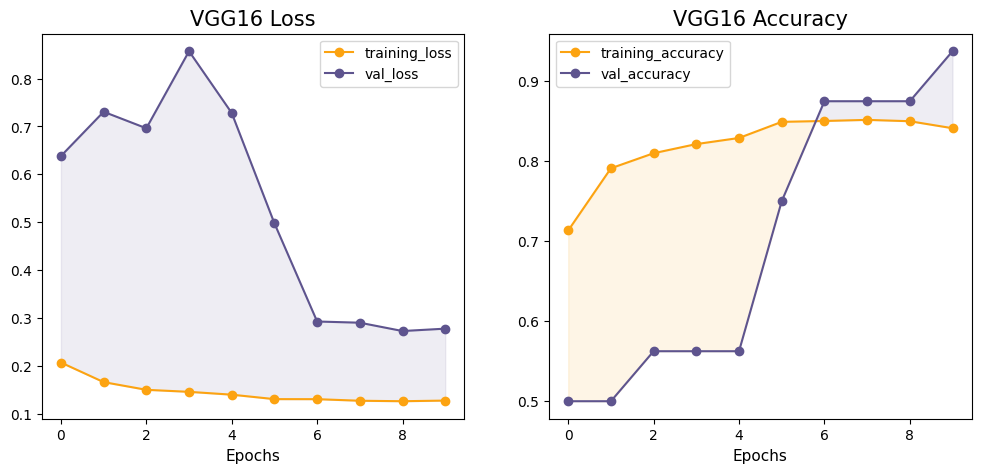

In [93]:
plot_training_curves(vgg_history, "VGG16")
plt.savefig("vgg_hist.png")
plt.show()

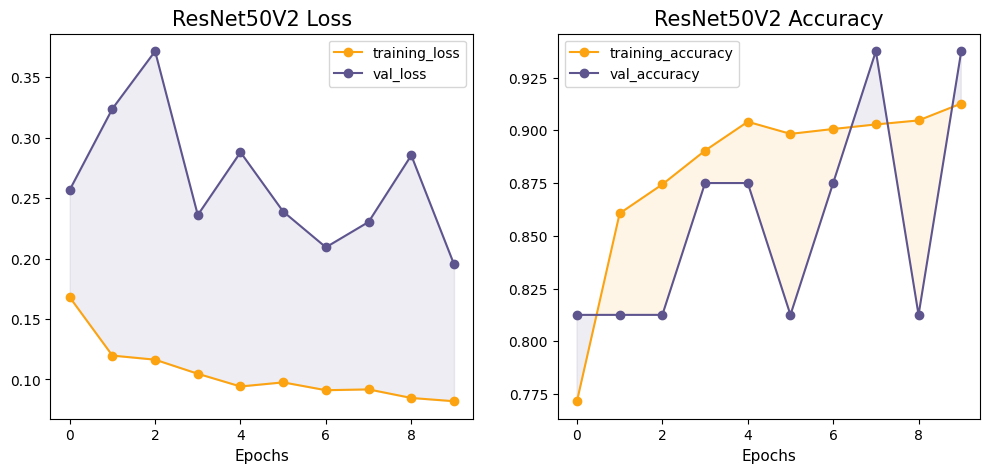

In [94]:
plot_training_curves(res_net_history, "ResNet50V2")
plt.savefig("res_net_hist.png")
plt.show()

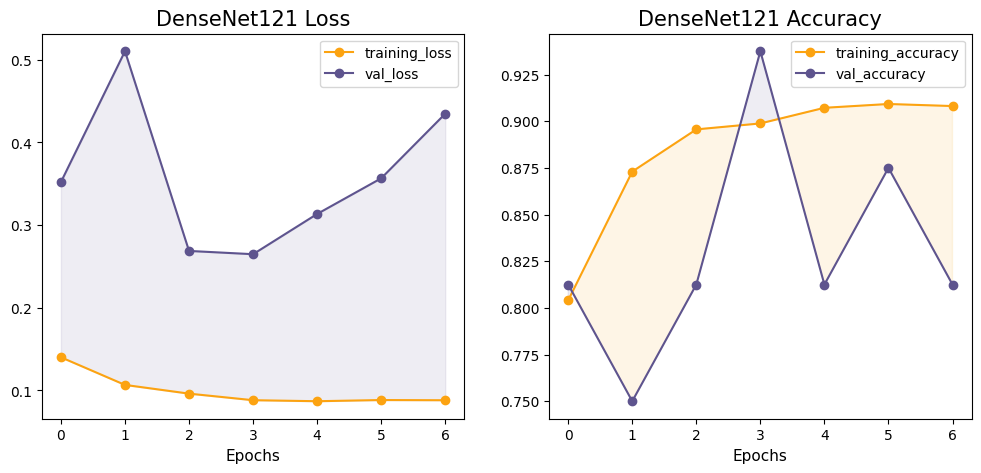

In [95]:

plot_training_curves(dense_history, "DenseNet121")
plt.savefig("dens_net_hist.png")
plt.show()

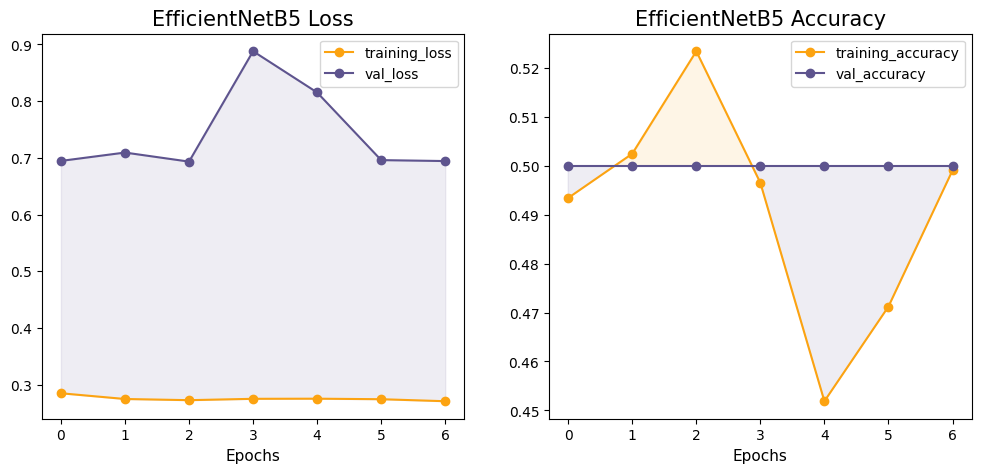

In [96]:
plot_training_curves(efficient_net_history, "EfficientNetB5")
plt.savefig("efficient_net_hist.png")
plt.show()

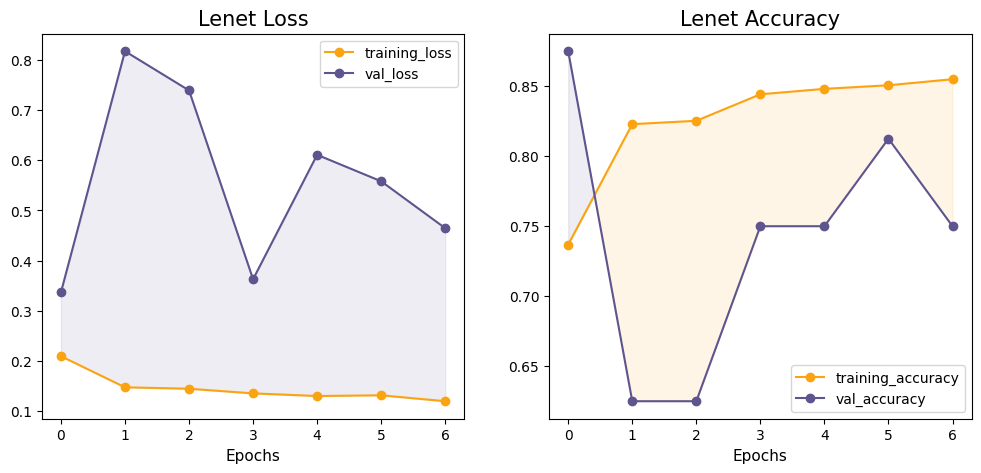

In [97]:
plot_training_curves(lenet_history, "Lenet")
plt.savefig("lenet_hist.png")
plt.show()

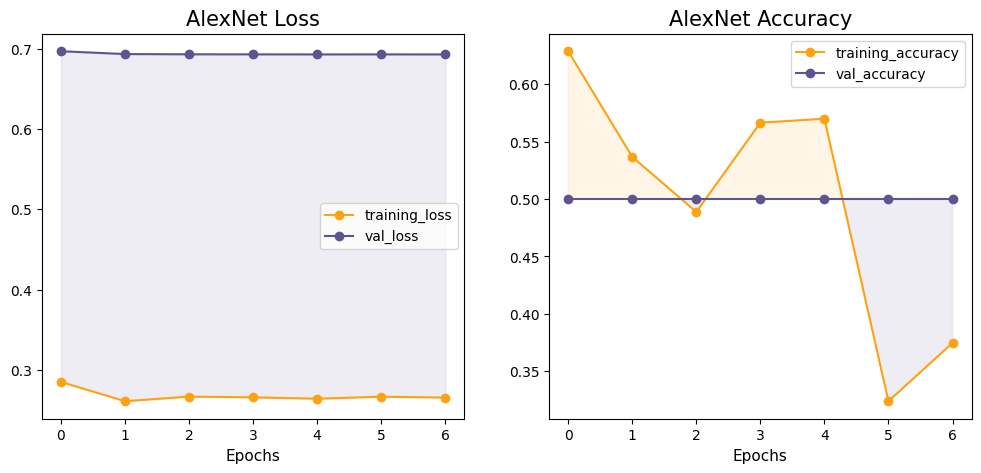

In [98]:
plot_training_curves(alexnet_history, "AlexNet")
plt.savefig("alexnet_hist.png")
plt.show()

In [148]:
tl_eval = pd.DataFrame({
    "metric": ["Loss", "Accuracy", "Precision", "Recall"],
    "VGG16": vgg_pred,
    "ResNet50V2": res_net_pred,
    "DenseNet121": dense_net_pred,
    "EfficientNetB5": efficient_net_model_pred,
    "LeNet": lenet_pred,
    "AlexNet": alexnet_pred
})

tl_eval = tl_eval.T.reset_index()
tl_eval.columns = list(tl_eval.iloc[0, :].values)
tl_eval = tl_eval.rename(columns={"metric": "Model"})
tl_eval = tl_eval.iloc[1:, :]
tl_eval = tl_eval.sort_values(by=["Accuracy", "Precision"], ascending=False)
tl_eval

,Model,Loss,Accuracy,Precision,Recall
2,ResNet50V2,0.278743,0.892628,0.95493,0.869231
3,DenseNet121,0.391455,0.844551,0.959248,0.784615
1,VGG16,0.380643,0.8125,0.912387,0.774359
5,LeNet,0.439259,0.809295,0.938511,0.74359
4,EfficientNetB5,0.693555,0.528846,0.585106,0.846154
6,AlexNet,0.71951,0.375,0.0,0.0


In [149]:
tl_eval.to_csv("/kaggle/working/TL_eval_vals.csv", index=False)

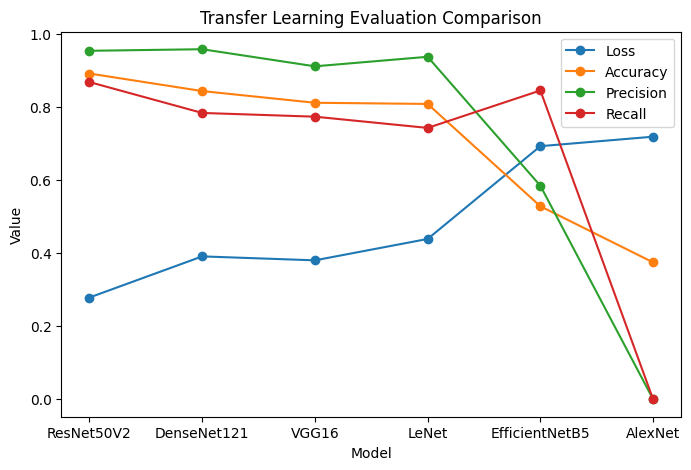

In [122]:
# Transfer Learning model performance
fig = plt.figure(figsize=(8, 5))

plt.plot(tl_eval["Model"], tl_eval["Loss"], label="Loss",  marker='o')
plt.plot(tl_eval["Model"], tl_eval["Accuracy"], label="Accuracy",  marker='o')
plt.plot(tl_eval["Model"], tl_eval["Precision"], label="Precision",  marker='o')
plt.plot(tl_eval["Model"], tl_eval["Recall"], label="Recall",  marker='o')
plt.legend()
plt.title("Transfer Learning Evaluation Comparison")
plt.xlabel("Model")
plt.ylabel("Value")
plt.savefig("TL_eval_plot.png")
plt.show()

In [135]:
# CNN model evaluation (Train/Test)
CNN_df = pd.DataFrame(metrics_list)
CNN_df = CNN_df.loc[CNN_df["Loss"] != ""].reset_index(drop=True)
CNN_df["Loss"] 

,Conv_Layers,Filters,Dropout_Rate,Activation,Optimizer,history,Loss,Accuracy,Precision,Recall
0,3,"[32, 64, 128]",0.2,relu,adam,<keras.src.callbacks.history.History object at...,6.348193,0.375,0.0,0.0
1,3,"[32, 64, 128]",0.2,relu,sgd,<keras.src.callbacks.history.History object at...,4.504457,0.625,0.625,1.0
2,3,"[32, 64, 128]",0.2,tanh,adam,<keras.src.callbacks.history.History object at...,1.90742,0.697115,0.686456,0.948718
3,3,"[32, 64, 128]",0.2,tanh,sgd,<keras.src.callbacks.history.History object at...,4.498787,0.625,0.625,1.0
4,3,"[32, 64, 128]",0.4,relu,adam,<keras.src.callbacks.history.History object at...,5.310709,0.625,0.625,1.0
5,3,"[32, 64, 128]",0.4,relu,sgd,<keras.src.callbacks.history.History object at...,4.670247,0.625,0.625,1.0
6,3,"[32, 64, 128]",0.4,tanh,adam,<keras.src.callbacks.history.History object at...,4.356401,0.623397,0.624398,0.997436
7,3,"[32, 64, 128]",0.4,tanh,sgd,<keras.src.callbacks.history.History object at...,4.557509,0.625,0.625,1.0
8,4,"[32, 64, 128, 256]",0.2,relu,adam,<keras.src.callbacks.history.History object at...,6.53499,0.625,0.625,1.0
9,4,"[32, 64, 128, 256]",0.2,relu,sgd,<keras.src.callbacks.history.History object at...,8.753063,0.625,0.625,1.0


In [159]:
# Extract test metrics
CNN_test_eval_df = CNN_df[[
    'Conv_Layers', 'Filters', 'Dropout_Rate', 'Activation', 'Optimizer', "Loss", 
    "Accuracy", "Precision", "Recall"
]]

CNN_test_eval_df.sort_values(by=["Precision", "Accuracy", "Recall"], ascending=False)

,Conv_Layers,Filters,Dropout_Rate,Activation,Optimizer,Loss,Accuracy,Precision,Recall
12,4,"[32, 64, 128, 256]",0.4,relu,adam,5.871896,0.735577,0.773723,0.815385
2,3,"[32, 64, 128]",0.2,tanh,adam,1.90742,0.697115,0.686456,0.948718
14,4,"[32, 64, 128, 256]",0.4,tanh,adam,3.282838,0.629808,0.628019,1.0
1,3,"[32, 64, 128]",0.2,relu,sgd,4.504457,0.625,0.625,1.0
3,3,"[32, 64, 128]",0.2,tanh,sgd,4.498787,0.625,0.625,1.0
4,3,"[32, 64, 128]",0.4,relu,adam,5.310709,0.625,0.625,1.0
5,3,"[32, 64, 128]",0.4,relu,sgd,4.670247,0.625,0.625,1.0
7,3,"[32, 64, 128]",0.4,tanh,sgd,4.557509,0.625,0.625,1.0
8,4,"[32, 64, 128, 256]",0.2,relu,adam,6.53499,0.625,0.625,1.0
9,4,"[32, 64, 128, 256]",0.2,relu,sgd,8.753063,0.625,0.625,1.0


In [160]:
CNN_test_eval_df.to_csv("/kaggle/working/CNN_test_eval.csv", index=False)

In [161]:
# Get top performing model (test evaluation)
CNN_top_eval = CNN_test_eval_df.loc[CNN_test_eval_df["Precision"].max() == CNN_test_eval_df["Precision"]]
CNN_top_eval

,Conv_Layers,Filters,Dropout_Rate,Activation,Optimizer,Loss,Accuracy,Precision,Recall
12,4,"[32, 64, 128, 256]",0.4,relu,adam,5.871896,0.735577,0.773723,0.815385


In [167]:
# Join CNN eval metrics with transfer learning
CNN_top_eval = CNN_top_eval[["Accuracy", "Precision", "Recall"]]
CNN_top_eval["Model"] = "CNN"

eval_df = pd.concat([tl_eval, CNN_top_eval])

In [199]:
# eval_df.to_csv("/kaggle/working/mdl_eval.csv", index=False)
eval_df

,Model,Loss,Accuracy,Precision,Recall
2,ResNet50V2,0.278743,0.892628,0.95493,0.869231
3,DenseNet121,0.391455,0.844551,0.959248,0.784615
1,VGG16,0.380643,0.8125,0.912387,0.774359
5,LeNet,0.439259,0.809295,0.938511,0.74359
4,EfficientNetB5,0.693555,0.528846,0.585106,0.846154
6,AlexNet,0.71951,0.375,0.0,0.0
12,CNN,NaN,0.735577,0.773723,0.815385


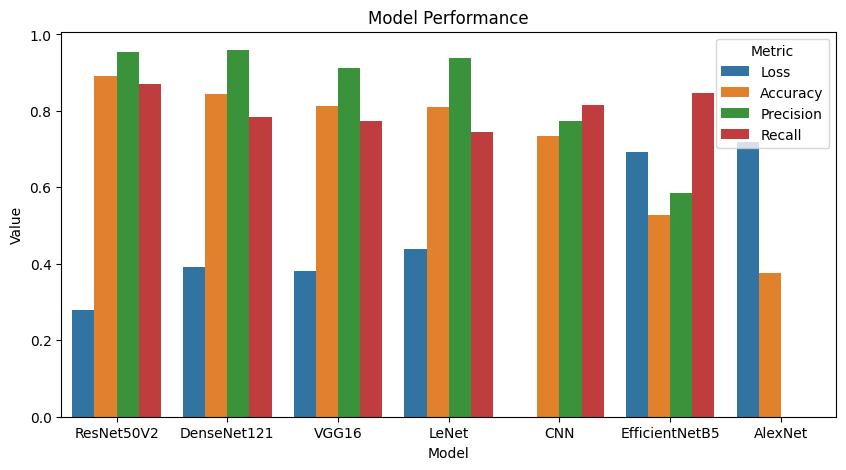

In [205]:
fig = plt.figure(figsize=(10, 5))

sns.barplot(
    data=eval_df.sort_values(by=["Accuracy", "Precision"], ascending=False).melt(id_vars="Model", var_name="Metric"),
    x="Model",
    y="value",
    hue="Metric"
)

plt.title("Model Performance")
plt.xlabel("Model")
plt.ylabel("Value")
plt.savefig("mdl_performance.png")
plt.show()

In [144]:
CNN_history = CNN_df[['Conv_Layers', 'Filters', 'Dropout_Rate', 'Activation', 'Optimizer', 'history']]
CNN_history

,Conv_Layers,Filters,Dropout_Rate,Activation,Optimizer,history
0,3,"[32, 64, 128]",0.2,relu,adam,<keras.src.callbacks.history.History object at...
1,3,"[32, 64, 128]",0.2,relu,sgd,<keras.src.callbacks.history.History object at...
2,3,"[32, 64, 128]",0.2,tanh,adam,<keras.src.callbacks.history.History object at...
3,3,"[32, 64, 128]",0.2,tanh,sgd,<keras.src.callbacks.history.History object at...
4,3,"[32, 64, 128]",0.4,relu,adam,<keras.src.callbacks.history.History object at...
5,3,"[32, 64, 128]",0.4,relu,sgd,<keras.src.callbacks.history.History object at...
6,3,"[32, 64, 128]",0.4,tanh,adam,<keras.src.callbacks.history.History object at...
7,3,"[32, 64, 128]",0.4,tanh,sgd,<keras.src.callbacks.history.History object at...
8,4,"[32, 64, 128, 256]",0.2,relu,adam,<keras.src.callbacks.history.History object at...
9,4,"[32, 64, 128, 256]",0.2,relu,sgd,<keras.src.callbacks.history.History object at...


In [169]:
CNN_history.to_csv("/kaggle/working/CNN_eval_history.csv", index=False)